# Tutorial for using RecurrentRLController

In this tutorial, we'll discuss how to setup a `RecurrentRLController` and its corresponding `ModelSpace`. 

We first construct a simple `ModelSpace` of four neural network layers, where each layer has five options of different computational operations.

Then we use the `RecurrentRLController` to perform reinforcement learning (RL) and update a LSTM controller with policy gradients. We will create a mock reward that scores substring pattern of `21`, and evaluate if RL can find the optimal solution.

For instance, in `ModelSpace` the five options for each layer is: 1=max-pooling, 2=convolution, 3=average-pooling, 4=dropout, 5=identity/zero. Our `RecurrentRLController` will seek to find `conv->maxpool` pairs via the mock reward. The optimal 4-layer architecture is `conv->maxpool->conv->maxpool`.

Notably, in practice, it is up to the `Modeler` to determine which architecture token (i.e., an integer $\in [1,5]$ in this case) maps to what operation. For now, we won't discuss `Modeler` yet.

---

## Table of Contents
1. [Create ModelSpace](#section1)
2. [Create Controller](#section2)
3. [How to understand the Residual connections?](#section3)
4. [Optimizing a black-box function](#section4)


<a id='section1'></a>
## Create ModelSpace

After importing what we need, we will create a `ModelSpace` with four layers.

For simplicity, we let each layer has five choices, so that the token embedding layers may be shared in the controller for our tutorial. We will model the choices as a random variable drawing integers ${1,2,3,4,5}$, as specified by `IntegerModelVariable`. The `name` Attribute is a unique identifier for a model variable and needs to be unique within a Model Space.

In specific use cases, you are free to explore any configurations, as long as instantiated via `IntegerModelVariable`. 


In [1]:
import amber
from amber.architect import IntegerModelVariable, ContinuousModelVariable
from amber.architect import ModelSpace
from amber import backend as F
import matplotlib.pyplot as plt
import numpy as np

# for reproducibility
F.set_seed(777)

In [2]:
model_space = ModelSpace.from_list([
    IntegerModelVariable(name='layer1_operator', min=1, max=5),
    IntegerModelVariable(name='layer2_operator', min=1, max=5),
    IntegerModelVariable(name='layer3_operator', min=1, max=5),
    IntegerModelVariable(name='layer4_operator', min=1, max=5),
])

model_space

ModelSpace([('layer1_operator', Variable(name=layer1_operator, value=3)),
            ('layer2_operator', Variable(name=layer2_operator, value=5)),
            ('layer3_operator', Variable(name=layer3_operator, value=1)),
            ('layer4_operator', Variable(name=layer4_operator, value=4))])

<a id='section2'></a>
## Create Controller

In [3]:
controller = amber.architect.controller.RecurrentRLController(
            model_space=model_space,
            with_skip_connection=True,
            lstm_size=64,
            lstm_num_layers=1,
            # these hyperparameters are important
            batch_size=5,
            buffer_size=15,
            train_pi_iter=5,
            temperature=3.5,
            #share_embedding={1:0, 2:0, 3:0}, # Optional
)

In [4]:
# by default, controller sample and evaluate architectures in its native format of a long Python List
arc, prob = controller.sample()
print('controller.sample() -> architecture token list:', arc)
res = controller.evaluate(arc)
print('controller.evaluate(arc) -> log-likelihood of arc:', res[0])

controller.sample() -> architecture token list: [1 2 0 4 1 0 2 0 1 1]
controller.evaluate(arc) -> log-likelihood of arc: tensor([10.5961], grad_fn=<ViewBackward0>)


In [5]:
# you can also call the built-in architecture token decoder, which may be easier for Modeler construction
use_decoder = True
arc, prob = controller.sample(decode=use_decoder)
print('controller.sample(decode=True) -> architecture token list[0], values for IntegerModelVariable:', arc[0])
print('                               -> architecture token list[1], residual connections:', arc[1])
# if use_decoder to sample, you need encoder to evaluate
res = controller.evaluate(arc, encode=use_decoder)
print('controller.evaluate(arc, encode=True) -> log-likelihood of arc:', res[0])

controller.sample(decode=True) -> architecture token list[0], values for IntegerModelVariable: [0, 2, 0, 2]
                               -> architecture token list[1], residual connections: [array([0], dtype=int32), array([1, 0], dtype=int32), array([1, 1, 1], dtype=int32)]
controller.evaluate(arc, encode=True) -> log-likelihood of arc: tensor([10.5967], grad_fn=<ViewBackward0>)


<a id='section3'></a>
## How to understand the Residual connections?
residual connections: [array([1], dtype=int32), array([0, 0], dtype=int32), array([1, 0, 0], dtype=int32)]

is equivalent to

|   |         | Layer 1 | Layer 2 | Layer 3 | 
|---|---------|---------|---------|---------|
|   | Layer 2 | 0/1     |         |         | 
|   | Layer 3 | 0/1     | 0/1     |         | 
|   | Layer 4 | 0/1     | 0/1     | 0/1     | 

<a id='section4'></a>
## Optimizing a black-box function

We will give a minimal example of using `RecurrentRLController` for optimization of a black-box function.

The function simply counts how many substrings of `21` in the sampled architecture. 

For instance, `f(arc=1234)=0`, `f(arc=0213)=f(arc=1215)=1`, and `f(arc=2121)=2`

In [6]:
def mock_modeler(arc: list) -> float:
    return ''.join([str(x) for x in arc]).count('21')

# test
mock_modeler([1,2,3,4]), mock_modeler([0,2,1,3]), mock_modeler([1,2,1,5]), mock_modeler([2,1,2,1])

(0, 1, 1, 2)

While this may seem like an easy enough task, it actually **is not**. 

- The model space has $5^4=625$ operation configurations, and there is only $1$ configuration that scores 2, $100$ configurations score 1, with the remaining $524$ configuration score 0. 

- More importantly, the score distribution is not smooth, thus not particularly "gradient-friendly".

- Since the `RecurrentRLController` also samples the residual connections, that further expand the model space by $2^{(1+2+3)}=64$ times, so we have a total of $40,000$ possible models.


As you'll see below, we only need to sample fewer than $250$ to converge to this optimal architecture. 

But, I won't lie to you, it is more likely to converge to the sub-optimal architectures with a score of 1, for the reasons listed above. 

The RL optimization hyperparameters play an essential role here. If you think NAS is a complete hands-free approach, unfortunately it isn't. For example, setting `train_pi_iter=20` will lead to more probable convergence to score 1 architectures because the controller would be trained too hard before it can explore other possibilities. Same applies to a lower temperature e.g. `temperature=1.5`.


In [7]:
%%time
max_iter = 50
rewards = []
for _ in range(max_iter):
    # sample 5 arcs in each iteration
    B = 5
    inner_rewards = []
    for i in range(B):
        arc, prob = controller.sample()
        # only score the ModelVariables, not the residual connections
        ops = controller.decoder.decode(arc)[0]
        reward = mock_modeler(ops)
        controller.store(action=arc, prob=prob, reward=reward)
        inner_rewards.append(reward)
    rewards.append(sum(inner_rewards)/B)
    controller.train()


CPU times: user 3min 14s, sys: 3.38 s, total: 3min 17s
Wall time: 24.8 s


Text(0, 0.5, 'Reward')

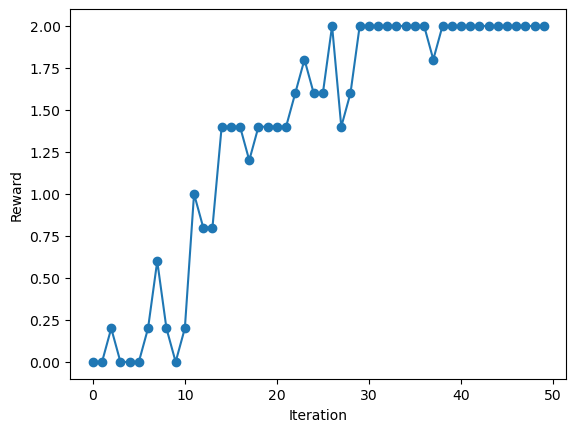

In [8]:
# visualize the rewards over search
fig, ax = plt.subplots()
ax.plot(np.arange(len(rewards)), rewards, marker='o')
ax.set_xlabel('Iteration')
ax.set_ylabel('Reward')


In [9]:
controller.sample()

(array([2, 1, 0, 2, 1, 0, 1, 1, 1, 1], dtype=int32),
 [array([[1.09059270e-04, 3.80669292e-07, 9.99882698e-01, 1.08078694e-07,
          7.69347571e-06]], dtype=float32),
  array([[2.7739567e-08, 9.9999988e-01, 1.2032196e-08, 2.8596434e-08,
          6.9332756e-08]], dtype=float32),
  array([[[9.999939e-01, 6.109019e-06]]], dtype=float32),
  array([[1.0476174e-03, 8.5901580e-04, 9.9789906e-01, 1.8755643e-04,
          6.6570606e-06]], dtype=float32),
  array([[[0.11717558, 0.8828244 ],
          [0.7846031 , 0.21539688]]], dtype=float32),
  array([[6.1381594e-05, 9.9987411e-01, 4.3094860e-05, 1.5025145e-05,
          6.2842937e-06]], dtype=float32),
  array([[[7.3521867e-02, 9.2647809e-01],
          [3.8381788e-01, 6.1618209e-01],
          [7.5958860e-06, 9.9999237e-01]]], dtype=float32)])

We can see the `RecurrentRLController` successfully learned the optimal architecture `[2,1,2,1]`. Note we only score the Computational Operation part of the architecture, not the Residual Connections.

In [10]:
%load_ext watermark
%watermark -t -u -iv -a FrankZijunZhang -d 

Author: FrankZijunZhang

Last updated: 2023-12-11 01:34:55

amber     : 2.0.0b0
matplotlib: 3.8.2
numpy     : 1.26.2

